In [16]:
import cv2
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
import os
import pandas as pd
import json
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from timm.models.efficientnet import tf_efficientnet_b0_ns
import torch
from torch import nn
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.pooling import AdaptiveAvgPool2d
from sklearn.metrics import accuracy_score

In [2]:
data_path = "original_data"
processed_data_path = "processed_data"
models_path = "models"
batch_size = 8
epochs = 10
freeze_epochs = 2
display_step = 1
save_num = 1

In [3]:
metadata_train = pd.read_csv(os.path.join(processed_data_path, 'train.csv'))

In [4]:
class DeepFakeClassifierDataset(Dataset):
    def __init__(self, metadata, processed_data_path):
        self.metadata = metadata
        self.processed_data_path = processed_data_path
    
    def __getitem__(self, index):
        vid, cid, label = self.metadata.loc[index]
        img_path = os.path.join(self.processed_data_path, 'crops', vid, '{}.png'.format(cid))
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.moveaxis(img, 2, 0)
        return img, label, vid, cid
        
    def __len__(self):
        return len(self.metadata)

In [5]:
class DeepFakeClassifier(nn.Module):
    def __init__(self, encoder, encoder_features, dropout_rate=0.0):
        super().__init__()
        self.encoder = encoder
        self.avg_pool = AdaptiveAvgPool2d((1, 1))
        self.dropout = Dropout(dropout_rate)
        self.fc = Linear(encoder_features, 1)

    def forward(self, x):
        x = self.encoder.forward_features(x)
        x = self.avg_pool(x).flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

In [6]:
def train_epoch(model, optimizer, loss_functions, train_data_loader, history):
    for imgs, labels, *_ in train_data_loader:
        imgs = imgs.type(torch.float).cuda()
        labels = labels.type(torch.float).reshape(-1, 1).cuda()
        optimizer.zero_grad()
        label_predicted = model(imgs)
        loss = loss_functions(label_predicted, labels)
        loss.backward()
        optimizer.step()
        history.append(loss.cpu().detach().numpy())

In [7]:
#Костыль для тестов
idx = np.arange(len(metadata_train))
np.random.shuffle(idx)
part = metadata_train.loc[idx[:500]].reset_index()
part = part[part.columns[1:]]
#Конец костыля

data_train = DeepFakeClassifierDataset(part, processed_data_path)

In [8]:
encoder = tf_efficientnet_b0_ns(pretrained=True).cuda()
encoder_features = encoder.num_features
model = DeepFakeClassifier(encoder, encoder_features, 0.15).cuda()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
loss_function = torch.nn.BCELoss().cuda()
history = []

In [10]:
model.train()
if freeze_epochs is not None and freeze_epochs != 0:
    model.encoder.eval()
    for p in model.encoder.parameters():
        p.requires_grad = False
mean_dur = 0

for epoch in range(epochs):
    if epoch == freeze_epochs:
        model.encoder.train()
        for p in model.encoder.parameters():
            p.requires_grad = True
    start = time.time()
    
    train_data_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True,
                                   pin_memory=False, drop_last=True)
    train_epoch(model, optimizer, loss_function, train_data_loader, history)
    
    dur = time.time() - start
    mean_dur = (mean_dur*epoch + dur)/(epoch + 1)
    estimated = mean_dur * (epochs - epoch - 1)
    
    print('Epoch {} loss: {} duration: {} estimated: {}'.format(
        epoch + 1, np.mean(history[-len(data_train):]), 
        round(dur, 3), int(estimated)))

Epoch 1 loss: 12.962689399719238 duration: 18.877 estimated: 169
Epoch 2 loss: 10.297396659851074 duration: 7.566 estimated: 105
Epoch 3 loss: 6.965525150299072 duration: 21.982 estimated: 112
Epoch 4 loss: 5.258538246154785 duration: 21.752 estimated: 105
Epoch 5 loss: 4.21992826461792 duration: 21.794 estimated: 91
Epoch 6 loss: 3.5226690769195557 duration: 21.838 estimated: 75
Epoch 7 loss: 3.0215208530426025 duration: 21.773 estimated: 58
Epoch 8 loss: 2.645254611968994 duration: 22.05 estimated: 39
Epoch 9 loss: 1.0959208011627197 duration: 21.932 estimated: 19
Epoch 10 loss: 0.15178142488002777 duration: 21.903 estimated: 0


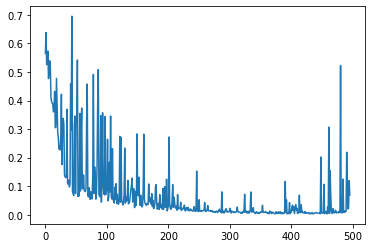

In [15]:
plt.plot(history[freeze_epochs * (len(history) // epochs):])

In [24]:
print("Save model? Current save number is {}.".format(save_num+1))
if(input().lower()[0] == "y"):
    save_num += 1
    torch.save(model, os.path.join(models_path, "classifier_{}.pth".format(save_num)))
    torch.save({'state_dict': model.state_dict()},
               os.path.join(models_path, "classifier_state_dict_{}.pth".format(save_num)))

Save models? Current save number is 1.
y


In [9]:
print("Load model?")
if(input().lower()[0] == "y"):
    load_num = input("Load number: ")
    state_dict = torch.load(os.path.join(models_path, "classifier_state_dict_{}.pth".format(load_num)))
    model.load_state_dict(state_dict['state_dict'])

Load model?
y
Load number: 1


In [11]:
metadata_test = pd.read_csv(os.path.join(processed_data_path, 'test.csv'))

#Костыль
idx = np.arange(len(metadata_test))
np.random.shuffle(idx)
part = metadata_test.loc[idx[:500]].reset_index()
part = part[part.columns[1:]]
#Конец костыля

data_test = DeepFakeClassifierDataset(part, processed_data_path)

In [29]:
model.eval()

predicted_labels = {}
labels = {}
for vid in data_test.metadata['vid'].unique():
    predicted_labels[vid] = []
    labels[vid] = int(data_test.metadata[data_test.metadata['vid'] == vid]['label'].iloc[0])

test_data_loader = DataLoader(data_test)
for img, label, vid, cid in tqdm(test_data_loader):
    img = img.type(torch.float).cuda()
    predicted_label = model(img).cpu().detach().numpy()
    predicted_labels[vid[0]].append(predicted_label)

for vid in predicted_labels:
    predicted_labels[vid] = int(np.mean(predicted_labels[vid]) >= 0.5)
    
print('Accuracy: {}'.format(accuracy_score(list(labels.values()),
                                           list(predicted_labels.values()))))


Accuracy: 0.9436619718309859
